In [1]:
import os
import random
import soundfile as sf
import torch
import yaml
import json
import argparse
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from pathlib import Path

import numpy as np 

import torch.nn as nn 
import torch.distributed as dist
from torch.utils.data import DataLoader, DistributedSampler

from asteroid.metrics import get_metrics
from asteroid.utils import tensors_to_device
from asteroid.dsp.normalization import normalize_estimates

import sys 
sys.path.append("/data1/wangyiwen/repos/graduateproject/speakerbeam/src/")
from models_direct.td_speakerbeam_sep2vec import TimeDomainSpeakerBeamPredictHelp 
from datasets.librimix_predict import LibriMixPredict, LibriMixPredictWithSep

from asteroid.utils.torch_utils import pad_x_to_y, jitable_shape
from asteroid.models.base_models import _shape_reconstructed, _unsqueeze_to_3d
from asteroid.models.base_models import BaseEncoderMaskerDecoder

In [2]:
model = TimeDomainSpeakerBeamPredictHelp(
    kernel_size=16,
    n_filters=512,
    stride=8,
    bn_chan=128,
    hid_chan=512,
    mask_act='relu',
    n_blocks=8,
    n_repeats=3,
    n_src=2,
    skip_chan=128,
    sample_rate=8000,
    adapt_enroll_dim=128,
    adapt_layer_type='mul',
    i_adapt_layer=7,
    causal=True,
)

In [3]:
model_path = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/20240717_mixloss_autoregression_fixed_pretrained_32sample_50epochcircle/checkpoints/epoch=349-step=202650.ckpt"
ckpt = torch.load(model_path, map_location=torch.device('cpu'))
state_dict = {} 
for k in ckpt['state_dict']: 
    state_dict[k.split('.',1)[1]] = ckpt['state_dict'][k]
# print(model.state_dict().keys())
model.load_state_dict(state_dict)
model.eval()

/tmp/ipykernel_2951558/891028740.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location=torch.device('cpu'))


TimeDomainSpeakerBeamPredictHelp(
  (encoder): Encoder(
    (filterbank): FreeFB()
  )
  (masker): TDConvNetInformedSeparateHelp(
    (bottleneck): Sequential(
      (0): CumLN()
      (1): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
    )
    (TCN): ModuleList(
      (0): Conv1DBlock(
        (shared_block): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): CumLN()
          (3): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), groups=512)
            (1): _Chop1d()
          )
          (4): PReLU(num_parameters=1)
          (5): CumLN()
        )
        (res_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
        (skip_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
      )
      (1): Conv1DBlock(
        (shared_block): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2

In [4]:
test_set = LibriMixPredict(
    csv_dir='data/wav8k/min/test',
    task='sep_noisy',
    sample_rate=8000,
    n_src=2,
    segment=3,
    segment_aux=3,
    delay_sample=32,
    return_filename=True,
)

Drop 0 utterances from 3000 (shorter than 3 seconds)
Drop 0 utterances from 6000 (shorter than 3 seconds)


In [5]:
embeddings_lists = []
embeddings_labels1 = []
embeddings_labels2 = []
from tqdm import tqdm 
for idx in tqdm(range(len(test_set))):
    test_data = test_set[idx]
    mix, source, enroll, delay_src, mixture_path, source_path, enroll_path = test_data 
    # est_source = model(mix.unsqueeze(0), enroll.unsqueeze(0), delay_src.unsqueeze(0))
    # print(est_source.shape)
    shape = jitable_shape(mix.unsqueeze(0))
    wav = _unsqueeze_to_3d(mix.unsqueeze(0))
    tf_rep = model.forward_encoder(wav)
    enroll_emb = model.auxiliary(enroll.unsqueeze(0))
    predict_emb = model.predict2vec(delay_src.unsqueeze(0))
    combine_emb = model.merge_embed(enroll_emb, predict_emb).detach().cpu().numpy()
    spk_id = enroll_path.split("/")[-1].split('-')[0] 
    spk_id2= enroll_path.split("/")[-1].split('-')[0]  + '-' + enroll_path.split("/")[-1].split('-')[1]
    embeddings_labels1.append(spk_id)
    embeddings_labels2.append(spk_id2)
    embeddings_lists.append(enroll_emb.detach().cpu().numpy())
    for i in range(50):
        embeddings_labels1.append(spk_id)
        embeddings_labels2.append(spk_id2)
        embeddings_lists.append(combine_emb[0, i:i+1])
    if idx >= 50:
        break

  1%|          | 50/6000 [00:08<17:46,  5.58it/s]


In [91]:
# print(embeddings_lists.shape)
emb_np = np.array(embeddings_lists)
emb_np = emb_np[:, 0, :]
emb_lst_np = np.array(embeddings_labels1)
print(emb_np.shape, emb_lst_np.shape)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# 示例数据
# data = np.random.rand(100, 256)  # 100 个样本，每个样本 256 维
# labels = np.array(["class1", "class2", "class3", "class1", "class2"] * 20)  # 100 个标签

# 将字符串标签转换为整数
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(emb_lst_np)

# 使用 t-SNE 将 256 维数据降到 2 维
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(emb_np)

(2601, 256) (2601,)


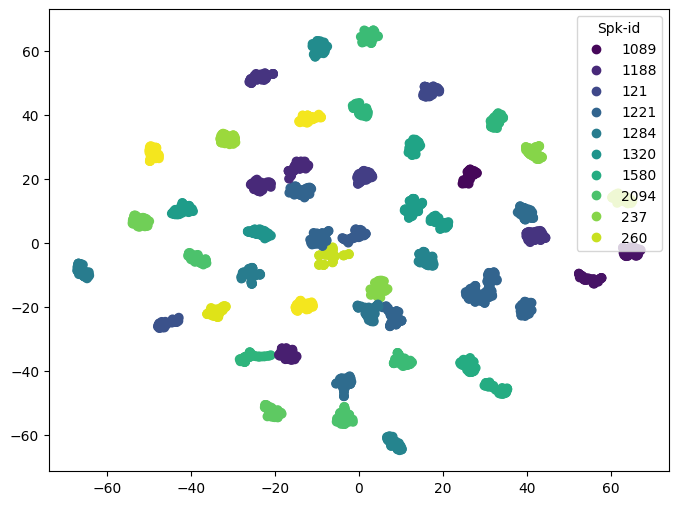

In [95]:
# 可视化结果
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=numeric_labels, cmap='viridis')
# plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), label='Labels')
plt.clim(-0.5, len(label_encoder.classes_) - 0.5)
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.title('t-SNE of High-Dimensional Data')

# 添加标签的图例
handles, _ = scatter.legend_elements(prop="colors")
legend_labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
# plt.legend(handles, legend_labels, title="Spk-id", loc="center left", bbox_to_anchor=(1, 0.5))
plt.legend(handles, legend_labels, title="Spk-id", loc="upper right")

# 调整布局以适应图例的位置
# plt.tight_layout(rect=[0, 0, 0.85, 1])  # 右边留出空间给legend

plt.show()

(2601, 256) (2601,)


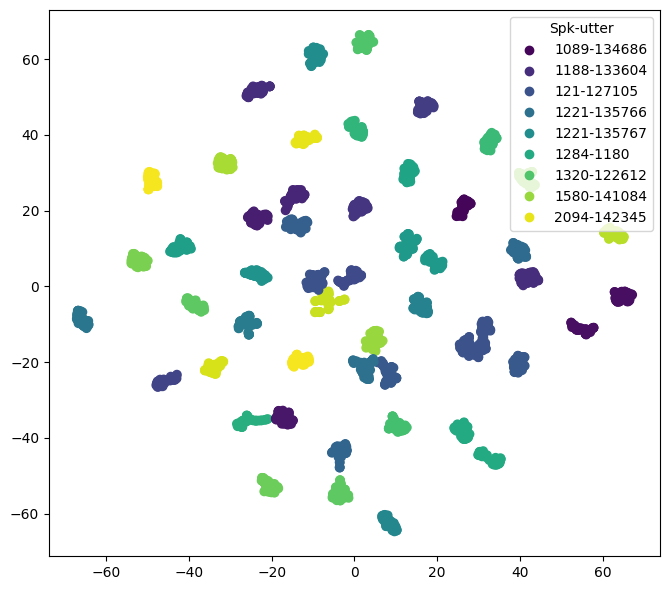

In [96]:
# print(embeddings_lists.shape)
# emb_np = np.array(embeddings_lists)
# emb_np = emb_np[:, 0, :]
emb_lst_np = np.array(embeddings_labels2)
print(emb_np.shape, emb_lst_np.shape)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# 示例数据
# data = np.random.rand(100, 256)  # 100 个样本，每个样本 256 维
# labels = np.array(["class1", "class2", "class3", "class1", "class2"] * 20)  # 100 个标签

# 将字符串标签转换为整数
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(emb_lst_np)

# 使用 t-SNE 将 256 维数据降到 2 维
# tsne = TSNE(n_components=2, random_state=42)
# reduced_data = tsne.fit_transform(emb_np)

# 可视化结果
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=numeric_labels, cmap='viridis')
# plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), label='Labels')
plt.clim(-0.5, len(label_encoder.classes_) - 0.5)
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.title('t-SNE of High-Dimensional Data')

# 添加标签的图例
handles, _ = scatter.legend_elements(prop="colors")
legend_labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
# plt.legend(handles, legend_labels, title="Spk-utter", loc="center left", bbox_to_anchor=(1, 0.5))
plt.legend(handles, legend_labels, title="Spk-utter", loc="upper right")

# 调整布局以适应图例的位置
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 右边留出空间给legend

plt.show()


(2601, 256) (2601,)


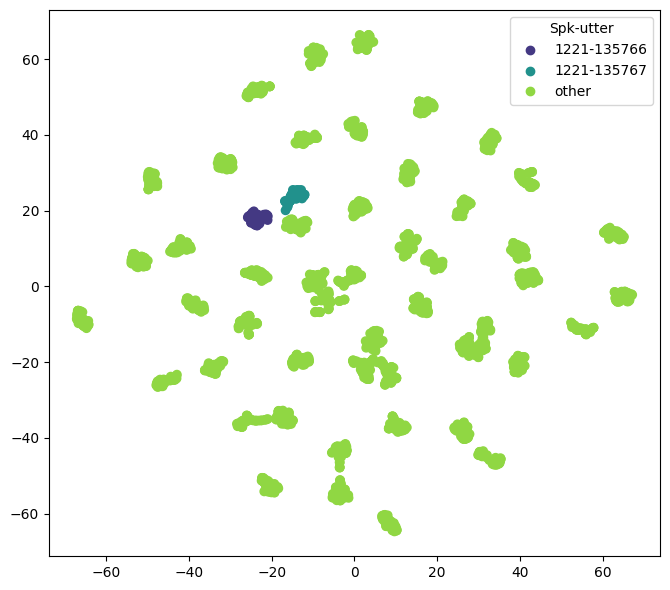

In [97]:
# print(embeddings_lists.shape)
# emb_np = np.array(embeddings_lists)
# emb_np = emb_np[:, 0, :]
emb_lst_np = np.array(embeddings_labels2)
print(emb_np.shape, emb_lst_np.shape)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# 示例数据
# data = np.random.rand(100, 256)  # 100 个样本，每个样本 256 维
# labels = np.array(["class1", "class2", "class3", "class1", "class2"] * 20)  # 100 个标签

# 将字符串标签转换为整数
emb_suffix = emb_lst_np[:]
emb_suffix_cp = []
for emb_lst in emb_suffix:
    if emb_lst[:4] == '1221':
    # if emb_lst[:4] == '260-':
        emb_suffix_cp.append(emb_lst)
    else:
        emb_suffix_cp.append('other')
# print(emb_suffix_cp)

label_encoder = LabelEncoder()
# numeric_labels = label_encoder.fit_transform(emb_lst_np)
numeric_labels = label_encoder.fit_transform(emb_suffix_cp)

# 使用 t-SNE 将 256 维数据降到 2 维
# tsne = TSNE(n_components=2, random_state=42)
# reduced_data = tsne.fit_transform(emb_np)

# 可视化结果
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=numeric_labels, cmap='viridis')
# plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), label='Labels')
plt.clim(-0.5, len(label_encoder.classes_) - 0.5)
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.title('t-SNE of High-Dimensional Data')

# 添加标签的图例
handles, _ = scatter.legend_elements(prop="colors")
legend_labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
# plt.legend(handles, legend_labels, title="Spk-utter", loc="center left", bbox_to_anchor=(1, 0.5))
plt.legend(handles, legend_labels, title="Spk-utter", loc="upper right")
# 调整布局以适应图例的位置
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 右边留出空间给legend

plt.show()


In [25]:
print(len(reduced_data), len(embeddings_labels2))

2601 2601


In [98]:
sel_data, sel_label = [], []
for i in range(len(reduced_data)):
    if  embeddings_labels2[i][:4] in ["2094", "260-", "121-", "1320", "1284"]: 
        # == "121-" or embeddings_labels2[i][:4] == "2094" or embeddings_labels2[i][:4] == "260-":
        # 237-
        sel_data.append(reduced_data[i])
        sel_label.append(embeddings_labels2[i])

sp shape:  (11, 2) 11 (561, 2)


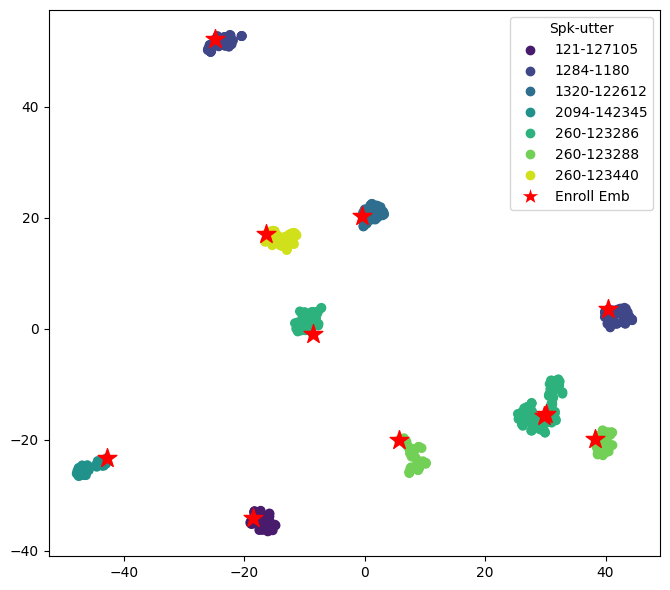

In [99]:
# print(embeddings_lists.shape)
# emb_np = np.array(embeddings_lists)
# emb_np = emb_np[:, 0, :]
# emb_lst_np = np.array(embeddings_labels2)
emb_sel_np = np.array(sel_data)
# print(emb_np.shape, emb_lst_np.shape)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# 示例数据
# data = np.random.rand(100, 256)  # 100 个样本，每个样本 256 维
# labels = np.array(["class1", "class2", "class3", "class1", "class2"] * 20)  # 100 个标签

# 将字符串标签转换为整数
# emb_suffix = emb_lst_np[:]
# emb_suffix_cp = []
# for emb_lst in emb_suffix:
#     if emb_lst[:4] == '1221':
#         emb_suffix_cp.append(emb_lst)
#     else:
#         emb_suffix_cp.append('other')
# print(emb_suffix_cp)

label_encoder = LabelEncoder()
# numeric_labels = label_encoder.fit_transform(emb_lst_np)
numeric_labels = label_encoder.fit_transform(sel_label)

# 使用 t-SNE 将 256 维数据降到 2 维
# tsne = TSNE(n_components=2, random_state=42)
# reduced_data = tsne.fit_transform(emb_np)

# 可视化结果
plt.figure(figsize=(8, 6))
scatter = plt.scatter(emb_sel_np[:, 0], emb_sel_np[:, 1], c=numeric_labels, cmap='viridis')
# plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), label='Labels')
plt.clim(-0.5, len(label_encoder.classes_) - 0.5)
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.title('t-SNE of High-Dimensional Data')
# special_points = np.array([emb_sel_np[0], emb_sel_np[51], emb_sel_np[102]])
special_points = np.array([emb_sel_np[51*i] for i in range(len(emb_sel_np) // 51)])
print("sp shape: ", special_points.shape, len(emb_sel_np) // 51, emb_sel_np.shape)

# 绘制星星形状的点
plt.scatter(special_points[:, 0], special_points[:, 1], color='red', marker='*', s=200, label='Enroll Embedding')

# 获取原有的 legend elements
handles, _ = scatter.legend_elements(prop="colors")

# 为 legend 添加特殊点的标注
special_handle = plt.Line2D([0], [0], marker='*', color='w', label='Special Points',
                            markerfacecolor='red', markersize=15)

# 组合 handles 和 labels
all_handles = handles + [special_handle]
legend_labels = list(label_encoder.inverse_transform(range(len(label_encoder.classes_)))) + ['Enroll Emb']

# 添加图例，并将其放到图的右侧外面
# plt.legend(all_handles, legend_labels, title="Spk-utter", loc="center left", bbox_to_anchor=(1, 0.5))
plt.legend(all_handles, legend_labels, title="Spk-utter", loc="upper right")

# 调整布局以适应图例的位置
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 右边留出空间给legend

plt.show()


In [48]:
sel_label[103]

'1188-133604'